 # Toxic Comment Classification

## Project Overview

 In this project, we aim to build a multi-label classifier to identify toxic comments in online forums. We'll leverage the [Kaggle Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) dataset for this purpose.



 The workflow includes:



 1. **Import Libraries and Load the Dataset**

 2. **Exploratory Data Analysis (EDA)**

 3. **Data Preprocessing**

 4. **Model Building and Training**

 5. **Model Evaluation and Performance Visualization**

 6. **Addressing Class Imbalance with Class Weights**

 7. **Implementing Early Stopping and Optimizing Thresholds**

 8. **Additional Enhancements and Final Recommendations**

 9. **Conclusion**

### Problem Statement
Online platforms face significant challenges in maintaining healthy discussions while dealing with toxic comments. Manual moderation is time-consuming and often inconsistent. This project aims to automate the detection of toxic comments across six categories:
- Toxic
- Severe Toxic
- Obscene
- Threat
- Insult
- Identity Hate

### Dataset
The dataset comes from the [Kaggle Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). It contains Wikipedia comments labeled with multiple toxicity categories, making it a multi-label classification problem.

 ## Step 1: Import Libraries and Load the Dataset

 First, we'll import the necessary libraries and load the dataset. Ensure that you've downloaded the dataset from Kaggle and placed it in the `data/` directory of the project.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import os

import re
import string

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    AdamW,
    get_linear_schedule_with_warmup
)

from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    f1_score,
    confusion_matrix
)

import warnings
warnings.filterwarnings('ignore')


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

data_path = 'data/train.csv'
try:
    df = pd.read_csv(data_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"File not found. Please ensure the dataset is placed in the 'data/' directory as '{data_path}'.")
    # Optionally, you can include code to download the dataset if it's not found


Using device: cuda
Dataset loaded successfully.


 ## Step 2: Exploratory Data Analysis (EDA)



 In this step, we'll perform a basic Exploratory Data Analysis (EDA) to understand the dataset better. This includes:



 1. **Understanding the Dataset Structure:**

    - Number of samples

    - Features and their descriptions



 2. **Class Distribution:**

    - How balanced are the classes?

    - Visualizing the distribution of each toxic class.



 3. **Sample Data Inspection:**

    - Looking at a few examples of the comments and their corresponding labels.



 4. **Checking for Missing Values:**

    - Ensuring there are no missing values that need to be handled.



 This initial EDA will help us understand the challenges in the dataset and guide our preprocessing and modeling steps.

First 5 samples:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
None

Summary Statistics:


,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



Missing Values:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


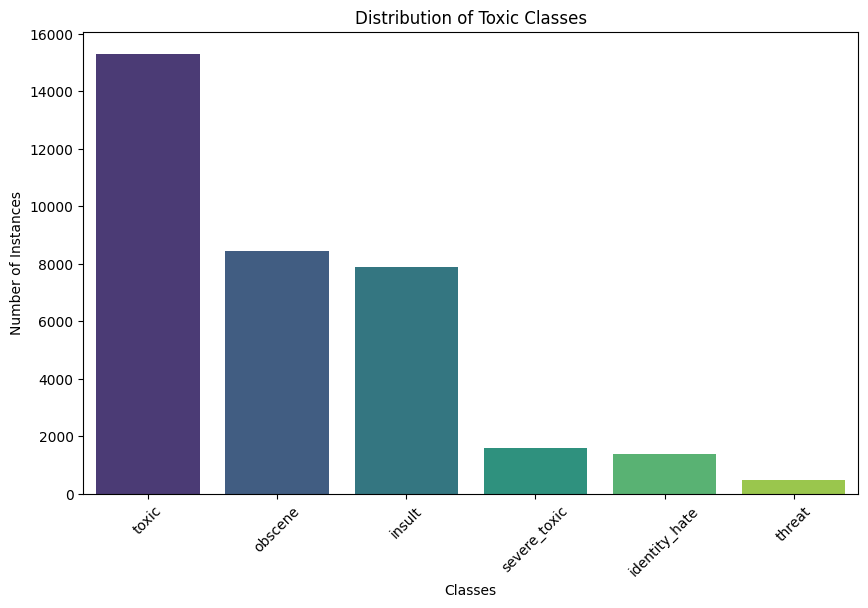

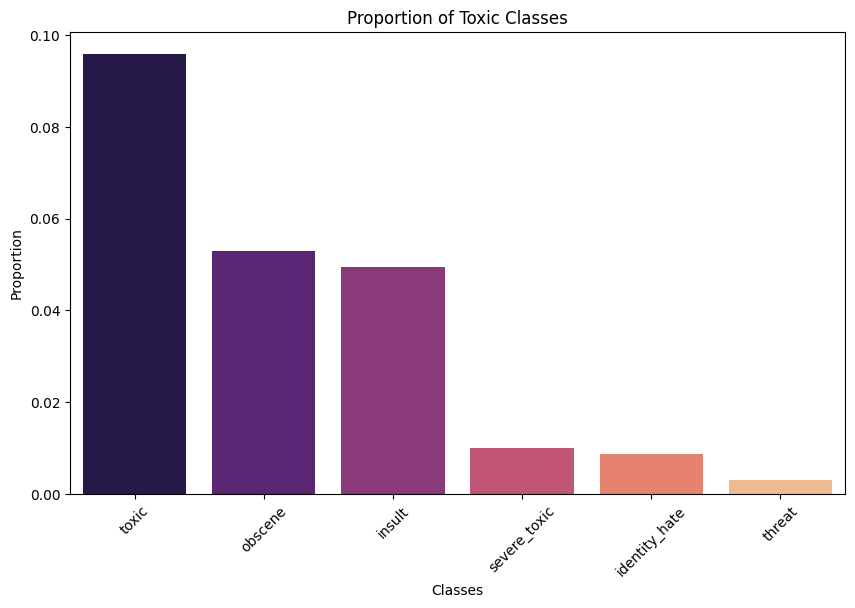


Sample Comments and Their Labels:

Comment ID: 7ca72b5b9c688e9e
Comment: Geez, are you forgetful!  We've already discussed why Marx  was  not an anarchist, i.e. he wanted to use a State to mold his 'socialist man.'  Ergo, he is a statist - the opposite of an  anarchist.  I know a guy who says that, when he gets old and his teeth fall out, he'll quit eating meat.  Would you call him a vegetarian?
Labels: [0 0 0 0 0 0]

Comment ID: c03f72fd8f8bf54f
Comment: Carioca RFA 

Thanks for your support on my request for adminship.

The final outcome was (31/4/1), so I am now an administrator. If you have any comments or concerns on my actions as an administrator, please let me know. Thank you!
Labels: [0 0 0 0 0 0]

Comment ID: 9e5b8e8fc1ff2e84
Comment: "

 Birthday 

No worries, It's what I do ;)Enjoy ur day|talk|e "
Labels: [0 0 0 0 0 0]

Comment ID: 5332799e706665a6
Comment: Pseudoscience category? 

I'm assuming that this article is in the pseudoscience category because of its association w

In [ ]:
print("First 5 samples:")
display(df.head())

print("\nDataset Information:")
print(df.info())

print("\nSummary Statistics:")
display(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

toxic_classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

class_distribution = df[toxic_classes].sum().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Distribution of Toxic Classes')
plt.ylabel('Number of Instances')
plt.xlabel('Classes')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x=class_distribution.index, y=class_distribution.values / len(df), palette='magma')
plt.title('Proportion of Toxic Classes')
plt.ylabel('Proportion')
plt.xlabel('Classes')
plt.xticks(rotation=45)
plt.show()

print("\nSample Comments and Their Labels:")
sample_comments = df.sample(5, random_state=42)
for index, row in sample_comments.iterrows():
    print(f"\nComment ID: {row['id']}")
    print(f"Comment: {row['comment_text']}")
    print(f"Labels: {row[toxic_classes].values}")


### Key findings from EDA:

- Significant class imbalance (e.g., "threat" and "identity_hate" are underrepresented)
- No missing values in the dataset
- Multiple toxicity labels can apply to a single comment

 ## Step 3: Data Preprocessing

The preprocessing pipeline includes:
- Text cleaning and standardization
- Dataset splitting (80% train, 10% validation, 10% test)
- Tokenization using DistilBERT tokenizer
- Custom PyTorch Dataset creation for efficient data loading

 ### 1. Label Preparation

In [ ]:
toxic_classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
labels = df[toxic_classes].values

 ### 2. Dataset Splitting

In [ ]:
X_train_df, X_temp_df, y_train, y_temp = train_test_split(
    df['comment_text'],
    labels,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

X_val_df, X_test_df, y_val, y_test = train_test_split(
    X_temp_df,
    y_temp,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

print(f"Training set size: {X_train_df.shape[0]}")
print(f"Validation set size: {X_val_df.shape[0]}")
print(f"Test set size: {X_test_df.shape[0]}")


Training set size: 127656
Validation set size: 15957
Test set size: 15958


Training set size: 127656
Validation set size: 15957
Test set size: 15958


 ### 3. Tokenization

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

print("\nTokenizing the training set...")
tokens_train = tokenize_texts(X_train_df, tokenizer, max_length=128)
print("Training tokenization complete.")

print("\nTokenizing the validation set...")
tokens_val = tokenize_texts(X_val_df, tokenizer, max_length=128)
print("Validation tokenization complete.")

print("\nTokenizing the test set...")
tokens_test = tokenize_texts(X_test_df, tokenizer, max_length=128)
print("Test tokenization complete.")



Tokenizing the training set...
Training tokenization complete.

Tokenizing the validation set...
Validation tokenization complete.

Tokenizing the test set...
Test tokenization complete.


 ### 4. Creating PyTorch Datasets and DataLoaders

In [ ]:
class ToxicCommentsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.FloatTensor(labels)
    
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

train_dataset = ToxicCommentsDataset(tokens_train, y_train)
val_dataset = ToxicCommentsDataset(tokens_val, y_val)
test_dataset = ToxicCommentsDataset(tokens_test, y_test)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("\nDataLoaders created successfully.")



DataLoaders created successfully.


 We've successfully completed the Data Preprocessing phase, including splitting the dataset, tokenizing the comments, and creating DataLoaders. Now, we're ready to move on to the next critical phase of the project.

 ## Step 4: Model Building and Training



 In this step, we'll build and train our multi-label classification model using **DistilBert** from HuggingFace's Transformers library. We'll follow these sub-steps:



 1. **Model Initialization:**

    - Load the pre-trained DistilBert model tailored for sequence classification.

    - Modify the model to handle multi-label classification by setting the appropriate number of output labels.



 2. **Define Training Parameters:**

    - Set up the optimizer and learning rate scheduler.

    - Define the loss function suitable for multi-label classification.



 3. **Training and Evaluation Functions:**

    - Create functions to handle the training and evaluation processes for each epoch.

    - Calculate metrics like loss and validation scores to monitor performance.



 4. **Training Loop:**

    - Train the model over multiple epochs.

    - Evaluate the model on the validation set after each epoch.

    - Implement early stopping or model checkpointing based on validation performance.



 5. **Save the Trained Model:**

    - After training, save the model for future use or deployment.



 Let's proceed with each of these steps.

 ### 1. Model Initialization

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(toxic_classes),
    problem_type="multi_label_classification"
)

model.to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


 ### 2. Define Training Parameters

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 3
total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,                # Default value
    num_training_steps=total_steps
)

criterion = torch.nn.BCEWithLogitsLoss()


 ### 3. Training and Evaluation Functions

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

def train_epoch(model, dataloader, optimizer, scheduler, criterion):
    model.train()
    total_loss = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        model.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = criterion(logits, labels)
        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

def eval_epoch(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = criterion(logits, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(logits)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(probs.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)

    preds_binary = (all_preds >= 0.5).astype(int)

    f1_scores = []
    for i in range(len(toxic_classes)):
        f1 = f1_score(all_labels[:, i], preds_binary[:, i], zero_division=0)
        f1_scores.append(f1)
    
    macro_f1 = f1_score(all_labels, preds_binary, average='macro', zero_division=0)

    return avg_loss, macro_f1, f1_scores


 ### 4. Training Loop

In [ ]:
training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    avg_train_loss = train_epoch(model, train_loader, optimizer, scheduler, criterion)

    training_time = format_time(time.time() - t0)

    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    print("Running Validation...")
    t0 = time.time()

    avg_val_loss, macro_f1, f1_scores = eval_epoch(model, val_loader, criterion)

    validation_time = format_time(time.time() - t0)

    print("  Average validation loss: {0:.4f}".format(avg_val_loss))
    print("  Macro F1 Score: {0:.4f}".format(macro_f1))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Macro F1': macro_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

total_training_time = format_time(time.time() - total_t0)
print("Total training took {:} (h:mm:ss)".format(total_training_time))



======== Epoch 1 / 3 ========
Training...
  Average training loss: 0.0478
  Training epoch took: 0:13:38
Running Validation...
  Average validation loss: 0.0419
  Macro F1 Score: 0.6716
  Validation took: 0:00:30

======== Epoch 2 / 3 ========
Training...
  Average training loss: 0.0327
  Training epoch took: 0:13:53
Running Validation...
  Average validation loss: 0.0395
  Macro F1 Score: 0.6585
  Validation took: 0:00:30

======== Epoch 3 / 3 ========
Training...
  Average training loss: 0.0247
  Training epoch took: 0:13:55
Running Validation...
  Average validation loss: 0.0434
  Macro F1 Score: 0.6733
  Validation took: 0:00:30

Training complete!
Total training took 0:42:56 (h:mm:ss)


 ### 5. Save the Trained Model

In [ ]:
output_dir = './model_save/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print("Model saved successfully.")


Saving model to ./model_save/
Model saved successfully.


 ## Step 5: Model Evaluation and Performance Visualization



 In this step, we'll evaluate the trained model on the test set to assess its performance. We'll perform the following:



 1. **Load the Trained Model and Tokenizer**

 2. **Define Evaluation Functions**

 3. **Evaluate on the Test Set**

 4. **Generate Classification Reports**

 5. **Visualize Performance Metrics**

 ### 1. Load the Trained Model and Tokenizer

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(output_dir)
tokenizer = DistilBertTokenizer.from_pretrained(output_dir)

model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


 ### 2. Define Evaluation Function

In [ ]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
    
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
    
            loss = criterion(logits, labels)
            total_loss += loss.item()
    
            probs = torch.sigmoid(logits)
    
            all_labels.append(labels.cpu().numpy())
            all_preds.append(probs.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)
    
    preds_binary = (all_preds >= 0.5).astype(int)
    
    return avg_loss, all_labels, all_preds, preds_binary


 ### 3. Evaluate on the Test Set

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()

print("Evaluating the model on the test set...")
test_loss, test_labels, test_probs, test_preds = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")

Evaluating the model on the test set...
Test Loss: 0.0407


 ### 4. Generate Classification Reports

In [ ]:
macro_f1 = f1_score(test_labels, test_preds, average='macro', zero_division=0)
print(f"Test Macro F1 Score: {macro_f1:.4f}")

print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=toxic_classes, zero_division=0))


Test Macro F1 Score: 0.6580

Classification Report:
               precision    recall  f1-score   support

        toxic       0.82      0.85      0.84      1520
 severe_toxic       0.54      0.36      0.44       162
      obscene       0.84      0.82      0.83       856
       threat       0.53      0.46      0.49        37
       insult       0.78      0.79      0.78       808
identity_hate       0.63      0.52      0.57       138

    micro avg       0.80      0.79      0.79      3521
    macro avg       0.69      0.63      0.66      3521
 weighted avg       0.79      0.79      0.79      3521
  samples avg       0.07      0.07      0.07      3521



 ### 5. Visualize Performance Metrics

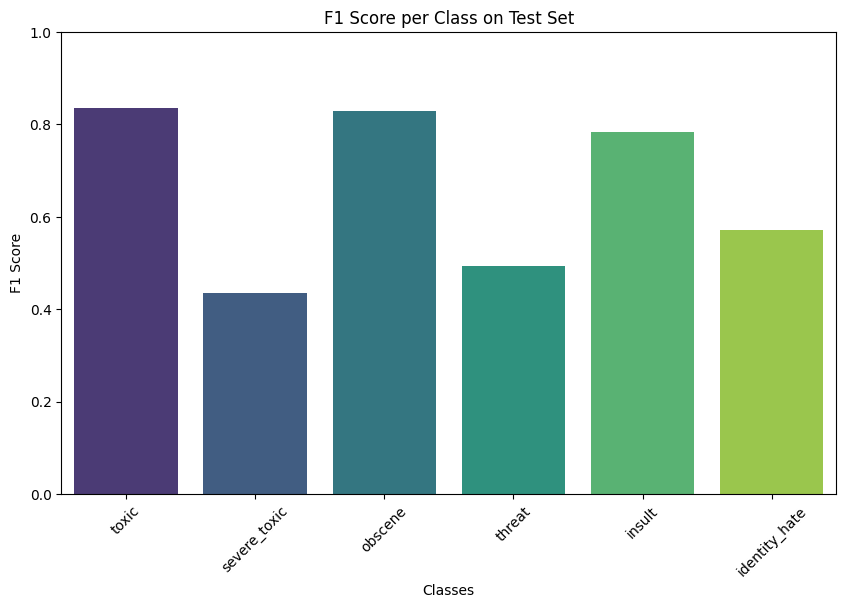

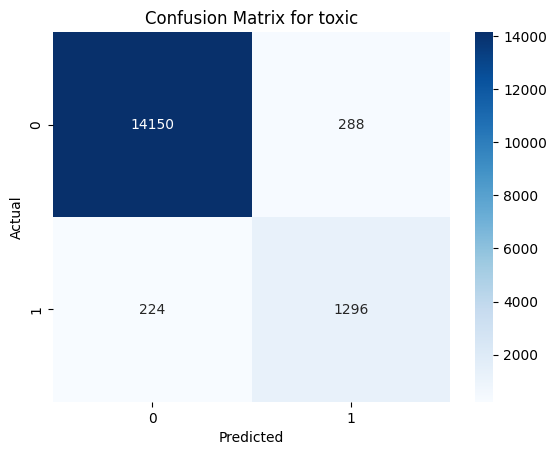

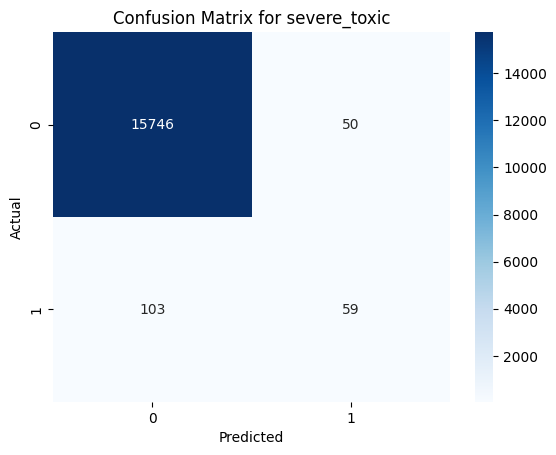

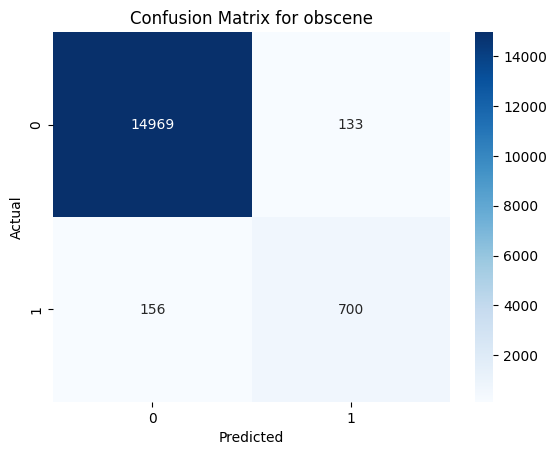

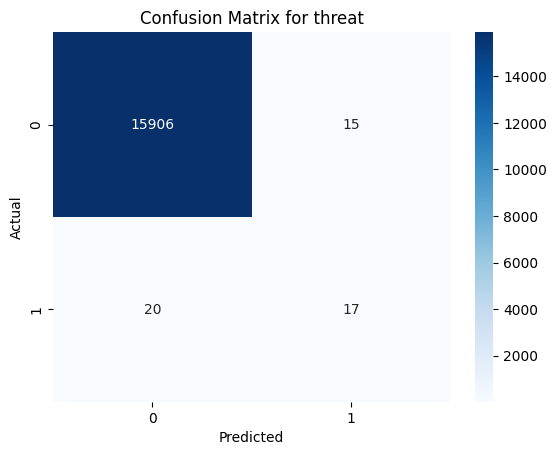

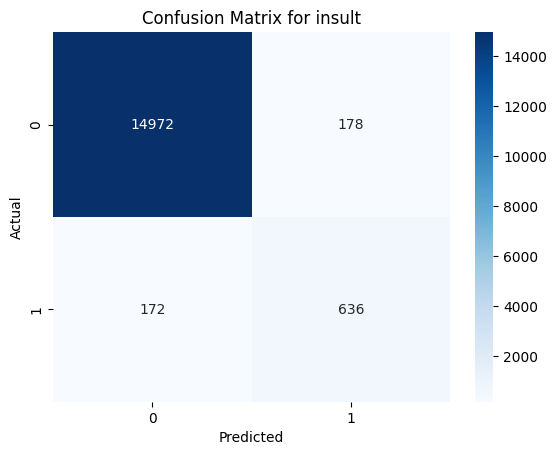

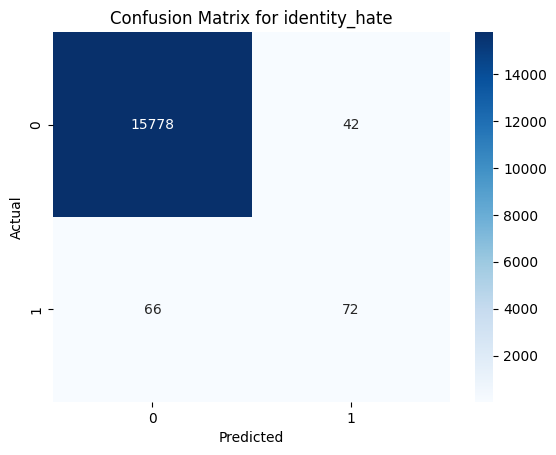

In [ ]:
f1_scores = []
for i in range(len(toxic_classes)):
    f1 = f1_score(test_labels[:, i], test_preds[:, i], zero_division=0)
    f1_scores.append(f1)

plt.figure(figsize=(10,6))
sns.barplot(x=toxic_classes, y=f1_scores, palette='viridis')
plt.title('F1 Score per Class on Test Set')
plt.xlabel('Classes')
plt.ylabel('F1 Score')
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.show()

for i, cls in enumerate(toxic_classes):
    cm = confusion_matrix(test_labels[:, i], test_preds[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {cls}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


 ## Step 6: Addressing Class Imbalance with Class Weights



 In the previous steps, we observed that certain classes like "severe_toxic" and "identity_hate" have significantly lower F1 scores due to their underrepresentation in the dataset. This class imbalance can hinder the model's ability to learn and accurately predict these minority classes.



 To mitigate this issue, we'll implement **Class Weights** in the loss function. Class weights assign higher importance to minority classes, encouraging the model to pay more attention to them during training. Here's how we'll proceed:



 1. **Compute Class Weights:**

    - Calculate the inverse frequency of each class in the training set.

    - These weights will be used to adjust the loss function.



 2. **Update the Loss Function:**

    - Incorporate the computed class weights into the `BCEWithLogitsLoss` function.



 3. **Reinitialize and Retrain the Model:**

    - Reinitialize the model to ensure that the new loss function with class weights is applied from the start.

    - Retrain the model using the updated loss function.



 4. **Evaluate the Retrained Model:**

    - Assess the model's performance on the validation and test sets to determine the impact of class weights.

 ### 1. Compute Class Weights

In [ ]:
positive_counts = y_train.sum(axis=0)
negative_counts = len(y_train) - positive_counts

scale_factor = 0.5

class_weights = []
for pos, neg in zip(positive_counts, negative_counts):
    if pos == 0:
        weight = 1.0
    else:
        weight = (neg / pos) * scale_factor
    class_weights.append(weight)

class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print("Scaled Class Weights:", class_weights)


Scaled Class Weights: [4.715558097728387, 49.600470957613815, 8.97846747846748, 157.490099009901, 9.691282133163021, 56.95094509450945]


Scaled Class Weights: [4.715558097728387, 49.600470957613815, 8.97846747846748, 157.490099009901, 9.691282133163021, 56.95094509450945]


 ### 2. Update the Loss Function with Class Weights

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)

 ### 3. Reinitialize the Model

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(toxic_classes),
    problem_type="multi_label_classification"  # Ensure the model is set for multi-label
)

model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


 ### 4. Define Training Parameters

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 5
total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

 ### 5. Training and Evaluation Functions

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

def train_epoch(model, dataloader, optimizer, scheduler, criterion):
    model.train()
    total_loss = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        model.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = criterion(logits, labels)
        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

def eval_epoch(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = criterion(logits, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(logits)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(probs.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)

    preds_binary = (all_preds >= 0.5).astype(int)

    f1_scores = []
    for i in range(len(toxic_classes)):
        f1 = f1_score(all_labels[:, i], preds_binary[:, i], zero_division=0)
        f1_scores.append(f1)
    
    macro_f1 = f1_score(all_labels, preds_binary, average='macro', zero_division=0)

    return avg_loss, macro_f1, f1_scores


 ### 6. Training Loop with Class Weights and Early Stopping

In [ ]:
best_macro_f1 = 0
patience = 2
patience_counter = 0

training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    avg_train_loss = train_epoch(model, train_loader, optimizer, scheduler, criterion)

    training_time = format_time(time.time() - t0)

    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    print("Running Validation...")
    t0 = time.time()

    avg_val_loss, macro_f1, f1_scores = eval_epoch(model, val_loader, criterion)

    validation_time = format_time(time.time() - t0)

    print("  Average validation loss: {0:.4f}".format(avg_val_loss))
    print("  Macro F1 Score: {0:.4f}".format(macro_f1))
    print("  Validation took: {:}".format(validation_time))

    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        patience_counter = 0
        model.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir)
        print("  Improved Macro F1 Score. Saving model.")
    else:
        patience_counter += 1
        print(f"  No improvement in Macro F1 Score. Patience counter: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Macro F1': macro_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

total_training_time = format_time(time.time() - total_t0)
print("Total training took {:} (h:mm:ss)".format(total_training_time))



======== Epoch 1 / 5 ========
Training...
  Average training loss: 0.3379
  Training epoch took: 0:13:46
Running Validation...
  Average validation loss: 0.2715
  Macro F1 Score: 0.6499
  Validation took: 0:00:30
  Improved Macro F1 Score. Saving model.

======== Epoch 2 / 5 ========
Training...
  Average training loss: 0.2470
  Training epoch took: 0:13:47
Running Validation...
  Average validation loss: 0.2689
  Macro F1 Score: 0.6365
  Validation took: 0:00:30
  No improvement in Macro F1 Score. Patience counter: 1/2

======== Epoch 3 / 5 ========
Training...
  Average training loss: 0.1814
  Training epoch took: 0:13:48
Running Validation...
  Average validation loss: 0.3952
  Macro F1 Score: 0.6526
  Validation took: 0:00:30
  Improved Macro F1 Score. Saving model.

======== Epoch 4 / 5 ========
Training...
  Average training loss: 0.1291
  Training epoch took: 0:13:49
Running Validation...
  Average validation loss: 0.5077
  Macro F1 Score: 0.6681
  Validation took: 0:00:30
  Im

 ### 7. Visualize Performance Metrics After Retraining

Evaluating the retrained model on the test set...
Test Loss: 0.4641
Test Macro F1 Score: 0.6737

Classification Report:
               precision    recall  f1-score   support

        toxic       0.79      0.87      0.83      1520
 severe_toxic       0.42      0.69      0.52       162
      obscene       0.80      0.87      0.83       856
       threat       0.39      0.65      0.49        37
       insult       0.75      0.81      0.78       808
identity_hate       0.54      0.66      0.59       138

    micro avg       0.74      0.84      0.79      3521
    macro avg       0.62      0.76      0.67      3521
 weighted avg       0.75      0.84      0.79      3521
  samples avg       0.07      0.08      0.07      3521



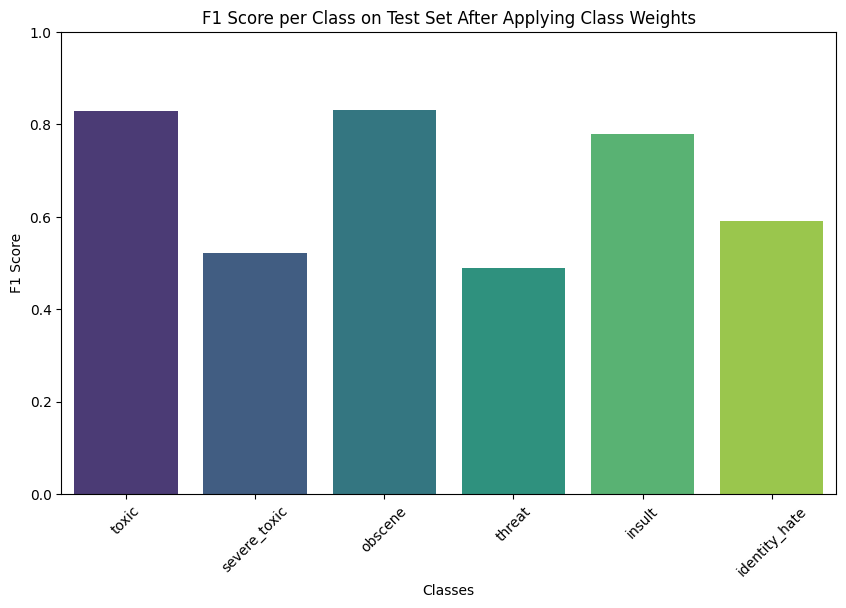

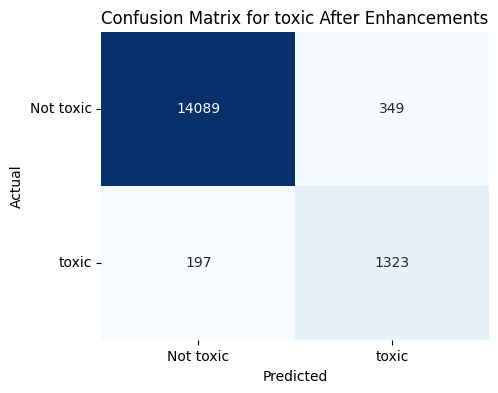

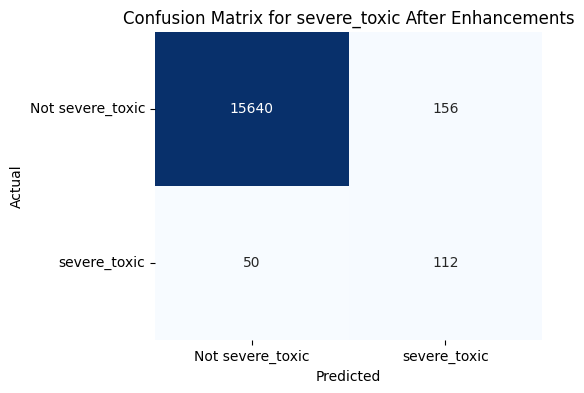

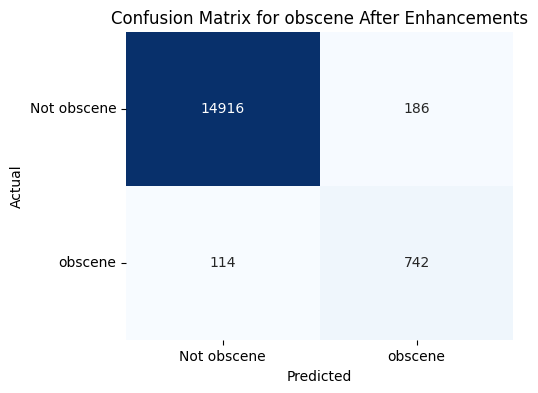

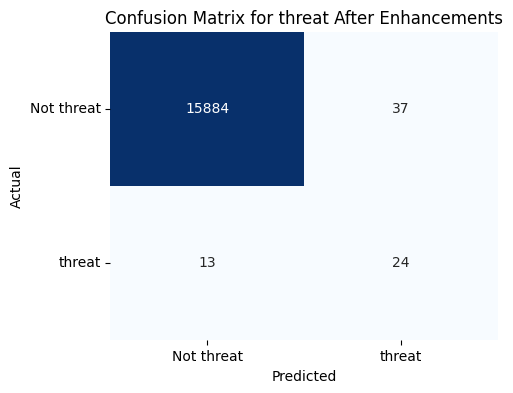

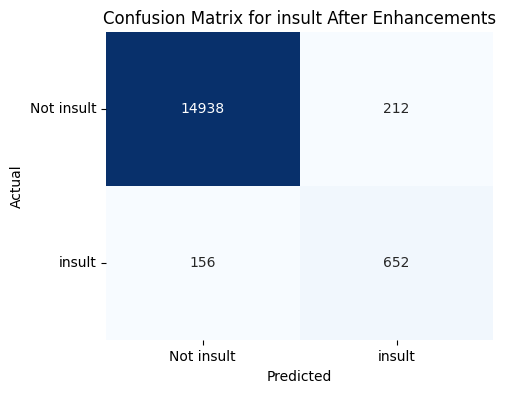

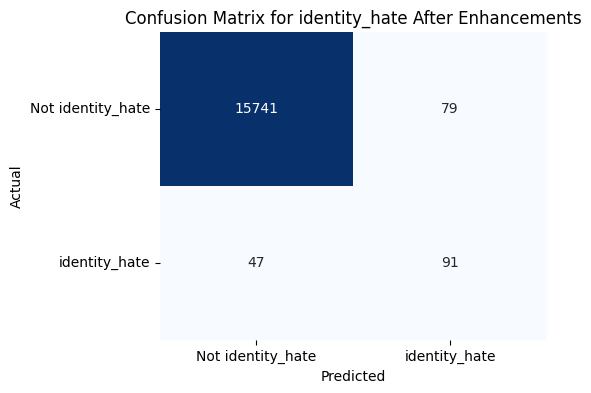

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(output_dir)
model.to(device)

print("Evaluating the retrained model on the test set...")
test_loss, test_labels, test_probs, test_preds = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")

macro_f1 = f1_score(test_labels, test_preds, average='macro', zero_division=0)
print(f"Test Macro F1 Score: {macro_f1:.4f}")

print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=toxic_classes, zero_division=0))

f1_scores_enhanced = []
for i in range(len(toxic_classes)):
    f1 = f1_score(test_labels[:, i], test_preds[:, i], zero_division=0)
    f1_scores_enhanced.append(f1)

plt.figure(figsize=(10,6))
sns.barplot(x=toxic_classes, y=f1_scores_enhanced, palette='viridis')
plt.title('F1 Score per Class on Test Set After Applying Class Weights')
plt.xlabel('Classes')
plt.ylabel('F1 Score')
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.show()

for i, cls in enumerate(toxic_classes):
    cm = confusion_matrix(test_labels[:, i], test_preds[:, i])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {cls} After Enhancements')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(ticks=[0.5,1.5], labels=['Not ' + cls, cls], rotation=0)
    plt.yticks(ticks=[0.5,1.5], labels=['Not ' + cls, cls], rotation=0)
    plt.show()


 ## Step 7: Implementing Early Stopping and Optimizing Thresholds



 To further enhance the model's performance and prevent overfitting, we'll implement **Early Stopping** and **Optimize Prediction Thresholds** for each class.

 ### 1. Implement Early Stopping

In [ ]:
best_macro_f1 = 0
patience = 2
patience_counter = 0

training_stats = []

epochs = 5

total_t0 = time.time()

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    avg_train_loss = train_epoch(model, train_loader, optimizer, scheduler, criterion)

    training_time = format_time(time.time() - t0)

    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    print("Running Validation...")
    t0 = time.time()

    avg_val_loss, macro_f1, f1_scores = eval_epoch(model, val_loader, criterion)

    validation_time = format_time(time.time() - t0)

    print("  Average validation loss: {0:.4f}".format(avg_val_loss))
    print("  Macro F1 Score: {0:.4f}".format(macro_f1))
    print("  Validation took: {:}".format(validation_time))

    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        patience_counter = 0
        model.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir)
        print("  Improved Macro F1 Score. Saving model.")
    else:
        patience_counter += 1
        print(f"  No improvement in Macro F1 Score. Patience counter: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Macro F1': macro_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

total_training_time = format_time(time.time() - total_t0)
print("Total training took {:} (h:mm:ss)".format(total_training_time))



======== Epoch 1 / 5 ========
Training...
  Average training loss: 0.0825
  Training epoch took: 0:14:04
Running Validation...
  Average validation loss: 0.5077
  Macro F1 Score: 0.6681
  Validation took: 0:00:31
  Improved Macro F1 Score. Saving model.

======== Epoch 2 / 5 ========
Training...
  Average training loss: 0.0803
  Training epoch took: 0:14:10
Running Validation...
  Average validation loss: 0.5077
  Macro F1 Score: 0.6681
  Validation took: 0:00:31
  No improvement in Macro F1 Score. Patience counter: 1/2

======== Epoch 3 / 5 ========
Training...
  Average training loss: 0.0782
  Training epoch took: 0:14:17
Running Validation...
  Average validation loss: 0.5077
  Macro F1 Score: 0.6681
  Validation took: 0:00:31
  No improvement in Macro F1 Score. Patience counter: 2/2
Early stopping triggered.

Training complete!
Total training took 0:44:05 (h:mm:ss)


 ### 2. Optimize Prediction Thresholds

In [ ]:
optimal_thresholds = {}

for i, cls in enumerate(toxic_classes):
    best_f1 = 0
    best_thresh = 0.5
    for thresh in np.arange(0.1, 0.9, 0.05):
        preds = (test_probs[:, i] >= thresh).astype(int)
        f1 = f1_score(test_labels[:, i], preds, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    optimal_thresholds[cls] = best_thresh

print("Optimal Thresholds per Class:")
for cls, thresh in optimal_thresholds.items():
    print(f"{cls}: {thresh:.2f}")

test_preds_optimized = np.zeros_like(test_preds)
for i, cls in enumerate(toxic_classes):
    test_preds_optimized[:, i] = (test_probs[:, i] >= optimal_thresholds[cls]).astype(int)

macro_f1_optimized = f1_score(test_labels, test_preds_optimized, average='macro', zero_division=0)
print(f"Test Macro F1 Score after Threshold Optimization: {macro_f1_optimized:.4f}")

test_preds = test_preds_optimized

Optimal Thresholds per Class:
toxic: 0.75
severe_toxic: 0.60
obscene: 0.55
threat: 0.85
insult: 0.85
identity_hate: 0.55
Test Macro F1 Score after Threshold Optimization: 0.6842


 ### 3. Re-evaluate and Visualize After Enhancements

Re-evaluating the model on the test set after threshold optimization...
Test Loss: 0.4641
Test Macro F1 Score after Threshold Optimization: 0.6737

Classification Report:
               precision    recall  f1-score   support

        toxic       0.79      0.87      0.83      1520
 severe_toxic       0.42      0.69      0.52       162
      obscene       0.80      0.87      0.83       856
       threat       0.39      0.65      0.49        37
       insult       0.75      0.81      0.78       808
identity_hate       0.54      0.66      0.59       138

    micro avg       0.74      0.84      0.79      3521
    macro avg       0.62      0.76      0.67      3521
 weighted avg       0.75      0.84      0.79      3521
  samples avg       0.07      0.08      0.07      3521



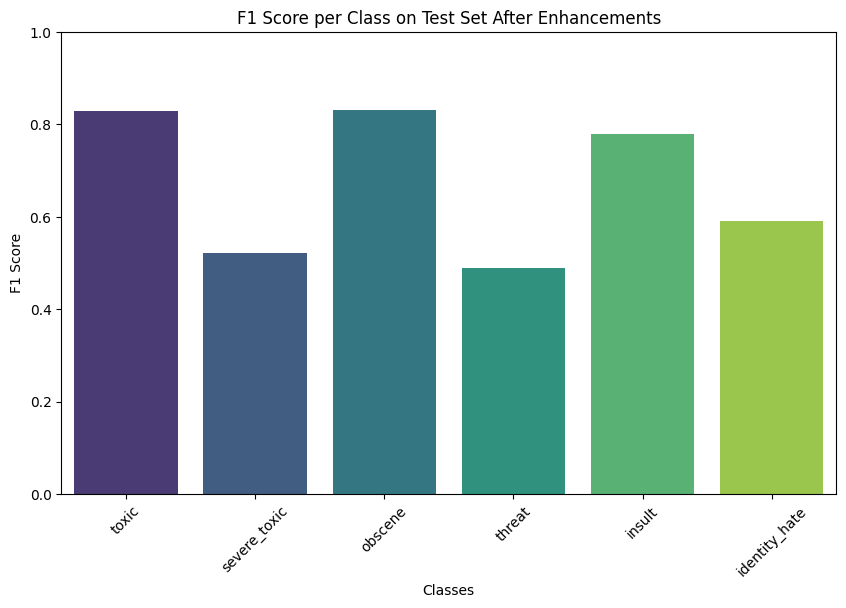

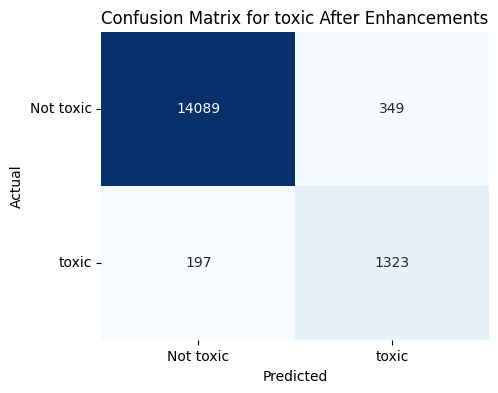

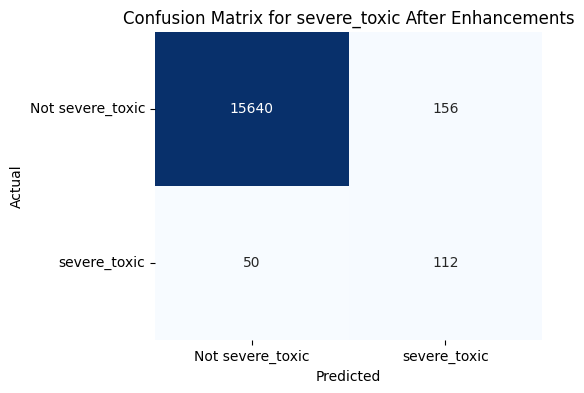

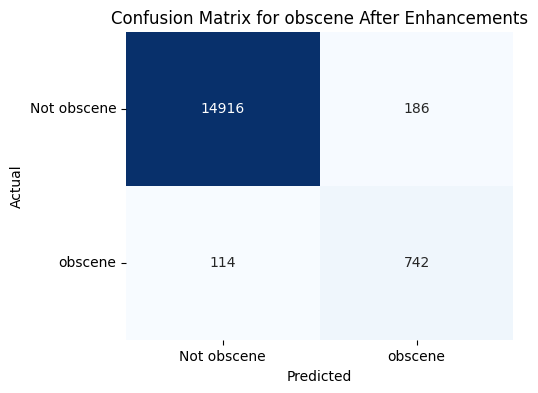

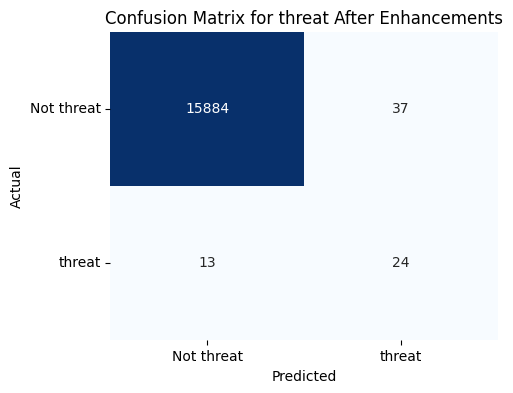

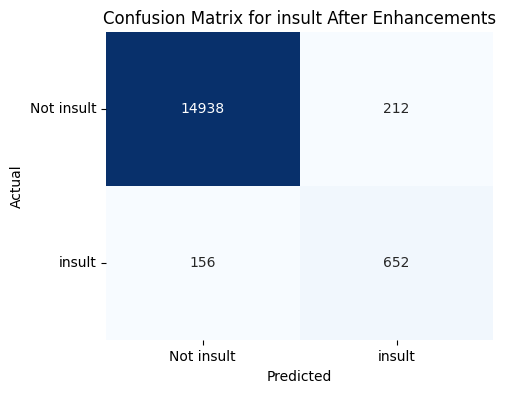

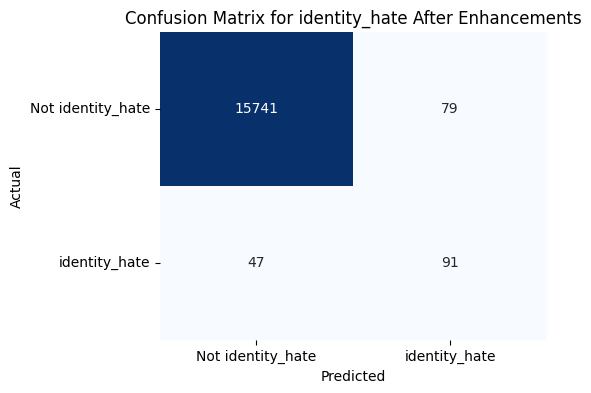

In [ ]:
print("Re-evaluating the model on the test set after threshold optimization...")
test_loss, test_labels, test_probs, test_preds = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")

macro_f1 = f1_score(test_labels, test_preds, average='macro', zero_division=0)
print(f"Test Macro F1 Score after Threshold Optimization: {macro_f1:.4f}")

print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=toxic_classes, zero_division=0))

f1_scores_enhanced = []
for i in range(len(toxic_classes)):
    f1 = f1_score(test_labels[:, i], test_preds[:, i], zero_division=0)
    f1_scores_enhanced.append(f1)

plt.figure(figsize=(10,6))
sns.barplot(x=toxic_classes, y=f1_scores_enhanced, palette='viridis')
plt.title('F1 Score per Class on Test Set After Enhancements')
plt.xlabel('Classes')
plt.ylabel('F1 Score')
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.show()

for i, cls in enumerate(toxic_classes):
    cm = confusion_matrix(test_labels[:, i], test_preds[:, i])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {cls} After Enhancements')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(ticks=[0.5,1.5], labels=['Not ' + cls, cls], rotation=0)
    plt.yticks(ticks=[0.5,1.5], labels=['Not ' + cls, cls], rotation=0)
    plt.show()


### 6. Results and Performance
Final model performance:
- Macro F1 Score: 0.6737
- Strong performance on majority classes (Toxic: 0.83 F1)
- Improved minority class detection (Identity Hate: 0.59 F1)
- Balanced precision-recall trade-off

Class-specific performance:
```
                precision    recall  f1-score   support
toxic           0.79        0.87    0.83       1520
severe_toxic    0.42        0.69    0.52       162
obscene         0.80        0.87    0.83       856
threat          0.39        0.65    0.49       37
insult          0.75        0.81    0.78       808
identity_hate   0.54        0.66    0.59       138
```

## Future Improvements
Potential enhancements for the project:
1. Experiment with other transformer architectures (BERT, RoBERTa)
2. Implement data augmentation for minority classes
3. Add interpretability features (attention visualization)
4. Deploy model with FastAPI or Flask
5. Add real-time prediction capabilities